In [7]:
import sys
import os
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [8]:
import h5py as h5
from radarlib.signal_processing import  LowPassFilter,IQDemodulator,BandPassFilter
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal,constants

In [9]:
MHz=1e6
GHz=1e9
us = 1e-6

In [10]:
test_file = '../data/sweep-1653691288.hdf5'
radar_file = '/home/alan/work/inspectobot/radar-analysis-tools/data/scan-1655933330.hdf5'

data_set = h5.File(radar_file ,'r')



In [11]:
data_i = data_set['sweep-0']

In [12]:
num_samples = data_i.attrs['sampleCount']
number_of_frequencies = data_i.attrs['frequencyCount']
number_of_channels = data_i.attrs['channelCount']
start_frequency = data_i.attrs['startFrequency']*MHz
step_frequency = data_i.attrs['stepFrequency']*MHz
intermediate_frequency = data_i.attrs['intermediateFreq']*MHz
transmit_power = data_i.attrs['transmitPower']
lo_power = data_i.attrs['loPower']

Fs = 122.88e6
Ts = 1/Fs
num_channels,N,num_samples = data_i.shape

In [13]:
raw_filter = BandPassFilter(fc=32e6, bw=2e6, ft=4e6, number_of_taps=32, fs=122.88e6, ts=0e-6,N=num_samples)
#raw_filter = LowPassFilter(fc=40e6, ft=1e6, number_of_taps=256, fs=122.88e6, ts=1e-6, n=num_samples)

offset = raw_filter.get_settling_time()

In [14]:
data = np.zeros((num_channels,N,num_samples-offset))
for a_scan in range(N):
        dut,_ = raw_filter(data_i[0,a_scan,:])
        ref,_ = raw_filter(data_i[1,a_scan,:])
        data[0,a_scan,:] = dut
        data[1,a_scan,:] = ref

num_samples = num_samples-offset


In [15]:
if_filter = IQDemodulator(f_lo=intermediate_frequency+4e6, fc=4e6, ft=1e6, number_of_taps=64,fs=122.88e6, ts=0e-6, n=num_samples)
bb_filter = LowPassFilter(fc=0.5e6, ft=1e6, number_of_taps=64, fs=122.88e6, ts=4e-6, n=num_samples)

t = np.linspace(0,(num_samples-1)*Ts,num_samples);

bb_filter.get_settling_time()



492

In [16]:
a_scan = 10;
dut = data[0,a_scan,:]
ref = data[1,a_scan,:]

ref_n = ref/np.max(np.abs(ref))
ref_iq,lo,a=  if_filter (ref_n)
dut_iq,lo,a = if_filter (dut)
bb_mixer = np.multiply(dut_iq,np.conj(ref_iq))
bb = bb_filter(bb_mixer)



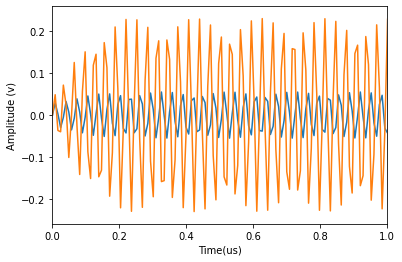

In [17]:
plt.plot(t/us,dut)
plt.plot(t/us,ref)
plt.xlim([0,1])
plt.xlabel("Time(us)");
plt.ylabel("Amplitude (v)");

In [18]:
len(dut),num_samples

(2048, 2048)

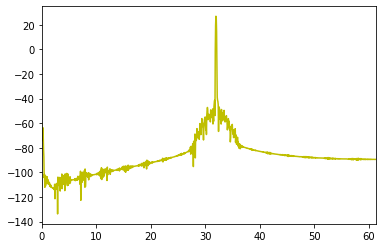

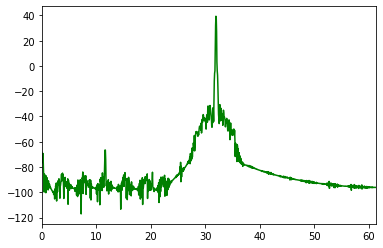

In [19]:
N = num_samples
M=N
f = np.linspace(0,Fs,M)
DUT = np.fft.fft(dut* np.kaiser(N, 9),M)/M*num_samples
REF = np.fft.fft(ref* np.kaiser(N, 9),M)/M*num_samples
plt.figure(1)
plt.plot(f/MHz,20*np.log10(np.abs(DUT)),'y')
plt.xlim([0,Fs/2/MHz]);
#plt.ylim(([-120,20]))
plt.figure(2)
plt.plot(f/MHz,20*np.log10(np.abs(REF)),'g')
plt.xlim([0,Fs/2/MHz]);
#plt.ylim(([-120,20]))


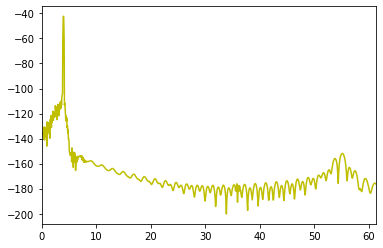

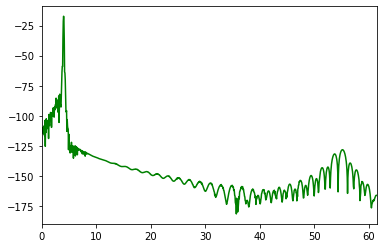

In [20]:
N = num_samples -if_filter.get_settling_time()
M=N
f = np.linspace(0,Fs,M)
DUTIQ = np.fft.ifft(dut_iq* np.kaiser(N,9),M)/M*N
REFIQ = np.fft.ifft(ref_iq* np.kaiser(N,9),M)/M*N
plt.figure(1)
plt.plot(f/MHz,20*np.log10(np.abs(DUTIQ)),'y')
plt.xlim([0,Fs/2/MHz]);

plt.figure(2)
plt.plot(f/MHz,20*np.log10(np.abs(REFIQ)),'g')
plt.xlim([0,Fs/2/MHz]);

In [21]:
num_channels,N,num_samples=data.shape
x = np.zeros(N, dtype=complex)

In [22]:
 for i in range(N):
        dut = data[0,i,:]
        ref = data[1,i,:]
        ref_iq,lo,a=  if_filter (ref)
        dut_iq,lo,a = if_filter (dut)
        ref_iq_n = np.exp(-1j*np.angle(ref_iq));
        bb_mixer = np.multiply(dut_iq,np.conj(ref_iq))
        bb,_= bb_filter(bb_mixer)
        x[i]=np.mean(bb)


In [23]:
len(x)

151

In [24]:
f = np.linspace(start_frequency, step_frequency*(N-1)+start_frequency,N)
dr = constants.c/(start_frequency*(num_samples-1))
r_max = constants.c/2/step_frequency

Text(0, 0.5, 'Phase in radians')

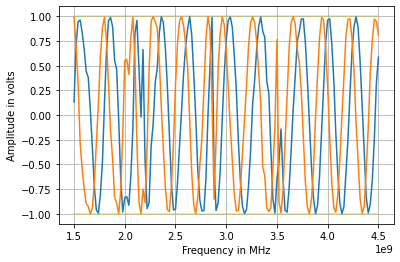

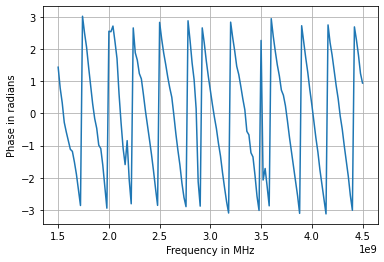

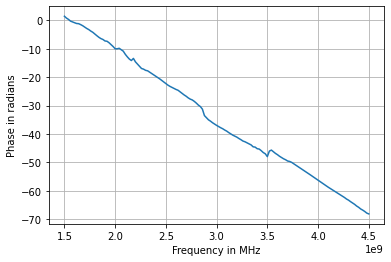

In [25]:
plt.figure(1)

x = x/np.abs(x)

plt.plot(f, np.real(x))
plt.plot(f, np.imag(x))
plt.plot(f,np.abs(x),'y',alpha=0.4)
plt.plot(f,-np.abs(x),'y',alpha=0.4)
plt.grid()
plt.xlabel('Frequency in MHz')
plt.ylabel('Amplitude in volts')

plt.figure(2)
plt.plot(f,np.angle(x))
plt.grid()
plt.xlabel('Frequency in MHz')
plt.ylabel('Phase in radians')

plt.figure(3)
plt.plot(f,np.unwrap(np.angle(x)))
plt.grid()
plt.xlabel('Frequency in MHz')
plt.ylabel('Phase in radians')


(0.0, 2.0)

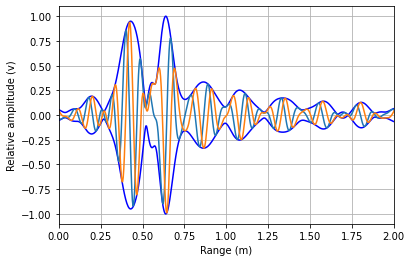

In [26]:

window = np.kaiser(N,6);
#window = signal.windows.dpss(N, 3)
#window = signal.windows.hamming(N)

z = np.fft.ifft(x*window,M)/M
z = z/np.max(np.abs(z))

r = np.linspace(0,r_max,M)
plt.plot(r,abs(z),'b')
plt.plot(r,-abs(z),'b')
plt.plot(r,z.real,r,z.imag);
plt.xlim([0,4])
plt.grid()
plt.xlabel('Range (m)')
plt.ylabel('Relative amplitude (v)')
plt.xlim([0,2])

(0.0, 2.0)

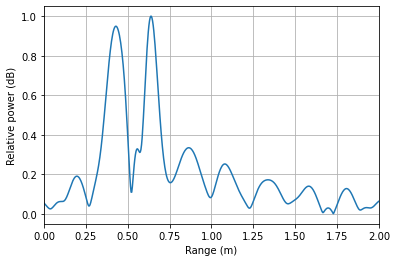

In [27]:
plt.plot(r,np.abs(z))
plt.grid()
plt.xlabel('Range (m)')
plt.ylabel('Relative power (dB)')
plt.xlim([0,2])

(0.0, 2.0)

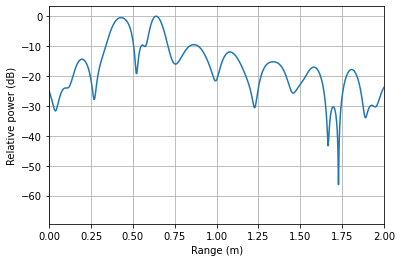

In [28]:
plt.plot(r,20*np.log10(np.abs(z)))
plt.grid()
plt.xlabel('Range (m)')
plt.ylabel('Relative power (dB)')
plt.xlim([0,2])

In [29]:
data_set.close()